# Load the dataset 

In [56]:
import pandas as pd
df=pd.read_csv("datasets/train.tsv",delimiter="\t")
df_good=df[df["Label"]==1]
df_bad=df[df["Label"]==2]
print("Done reading")

Done reading


# Categorical Histograms
Observing the histograms,We think that attribute1,attribute3,attribute4 and attribute7 can provide significant information as they have more than 3 values and you can see the deffernce between the goods and the bads.

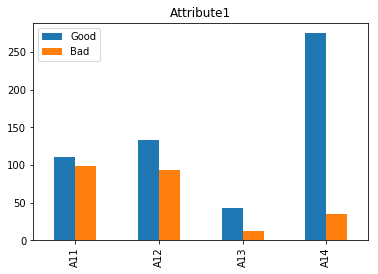

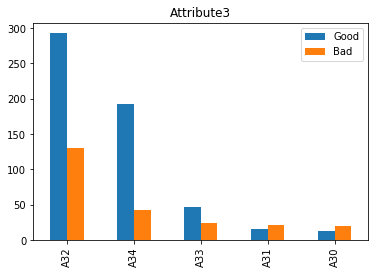

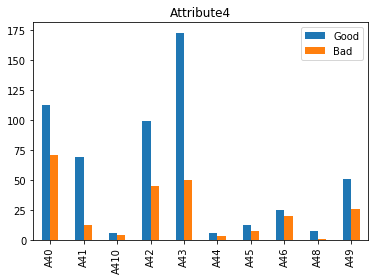

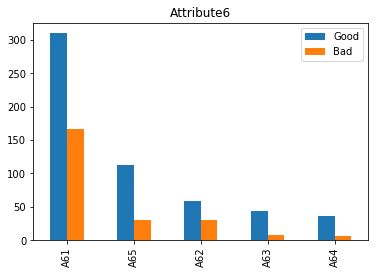

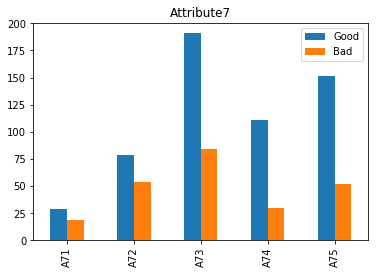

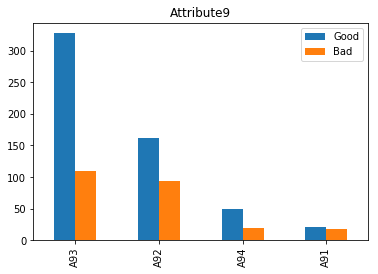

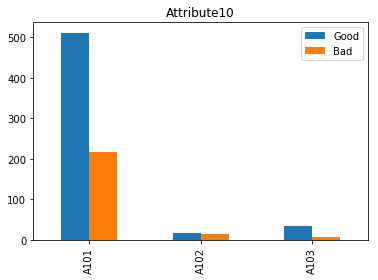

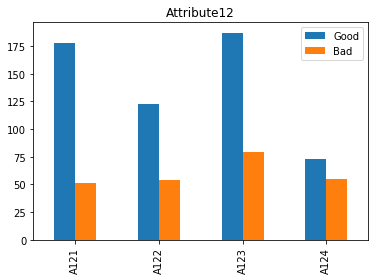

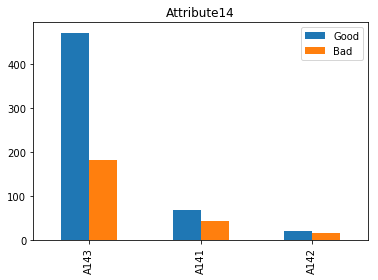

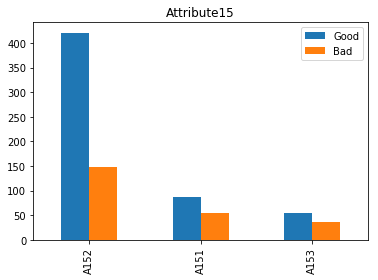

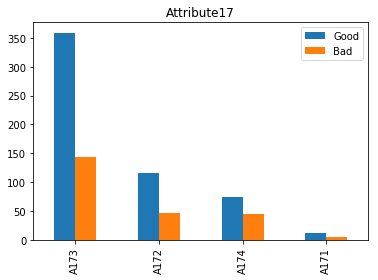

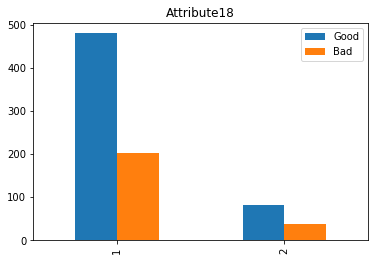

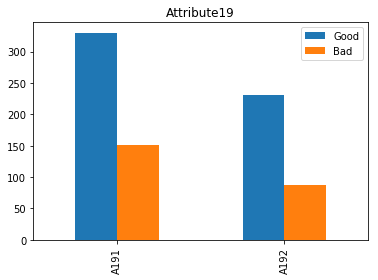

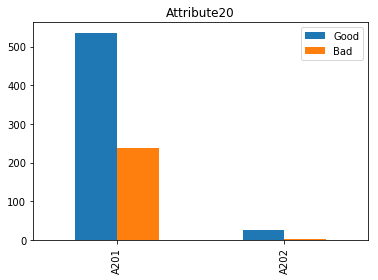

In [57]:
import matplotlib.pyplot as plt
cat_cat=["Attribute1","Attribute3","Attribute4","Attribute6","Attribute7","Attribute9","Attribute10",
         "Attribute12","Attribute14","Attribute15","Attribute17","Attribute18","Attribute19","Attribute20"]
for a_cat in cat_cat:
    new_df=pd.DataFrame({"Good":df_good[a_cat].value_counts(),"Bad":df_bad[a_cat].value_counts()},
                        columns=["Good","Bad"])
    new_df.plot(kind="bar",title=a_cat)
    plt.show()

# Numerical box plots
In these box plots , It's easy to say that the attribute2 and attribute5 provide significant information while the other attributes seem to be more unimportant.(Maybe Attribute8 is important?)

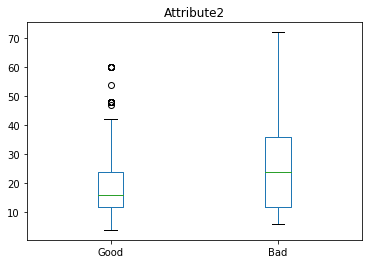

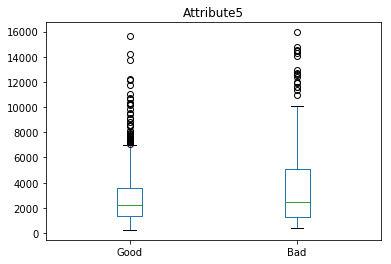

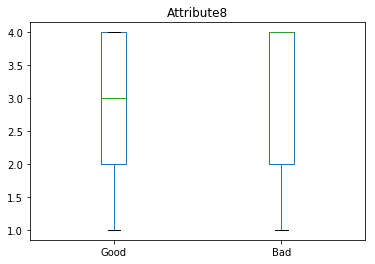

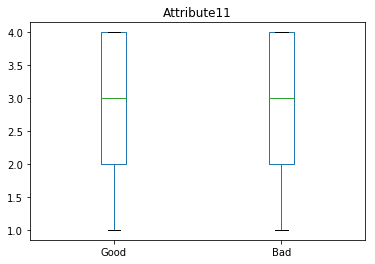

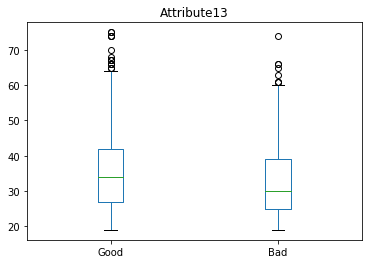

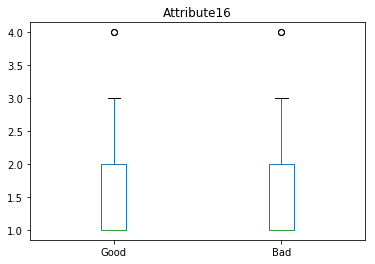

In [58]:
numerical_cat=["Attribute2","Attribute5","Attribute8","Attribute11","Attribute13","Attribute16"]
for a_cat in numerical_cat:
    new_df=pd.DataFrame({"Good":df_good[a_cat],"Bad":df_bad[a_cat]},
                        columns=["Good","Bad"])
    new_df.plot(kind="box",title=a_cat)
    plt.show()

# Classifiers
Convert categorical in numeratic and cut the id and label columns

In [59]:
#Copy the dataset
cat_trans=dict()
new_df=df.copy()
for a_cat in cat_cat:
    the_cat_new=pd.Categorical(df[a_cat])
    cat_trans[a_cat]=the_cat_new.categories
    new_df[a_cat]=the_cat_new.codes

#cut the unnecessary 
cat_not_needed=["Label","Id"]
cat_needed=df.columns.difference(cat_not_needed)
all_results=dict()

# Random Forest

In [67]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

n_splits=10
kf = KFold(n_splits=n_splits,shuffle=True)
avg_acc=0
for train,test in kf.split(new_df[cat_needed]):
    #geting the correct slices 
    my_data=new_df[cat_needed].loc[train]
    labels=new_df["Label"][train]
    #initializeing and fiting the Classifier
    rf_clf=RandomForestClassifier()
    rf_clf.fit(my_data,labels)
    #geting the predictions
    my_pred=rf_clf.predict(new_df[cat_needed].loc[test])
    #the metrics
    acc=accuracy_score(new_df["Label"][test],my_pred)
    avg_acc+=acc/n_splits
print(avg_acc)
all_results["Random Forest"]=avg_acc

0.7375


# SVM

In [62]:
from sklearn import svm
n_splits=10
kf = KFold(n_splits=n_splits,shuffle=True)
avg_acc=0
for train,test in kf.split(new_df[cat_needed]):
    #initializeing and fiting the Classifier
    svm_clas=svm.SVC()
    #geting the correct slices 
    my_data=new_df[cat_needed].loc[train]
    labels=new_df["Label"][train]
    svm_clas.fit(my_data,labels)
    #geting the predictions
    my_pred=svm_clas.predict(new_df[cat_needed].loc[test])
    #the metrics
    acc=accuracy_score(new_df["Label"][test],my_pred)
    avg_acc+=acc/n_splits
print(avg_acc)
all_results["SVM"]=avg_acc

0.70125


# Naive Bayes (Gaussian NB)

In [65]:
from sklearn.naive_bayes import GaussianNB
n_splits=10
kf = KFold(n_splits=n_splits,shuffle=True)
avg_acc=0
for train,test in kf.split(new_df[cat_needed]):
    #initializeing and fiting the Classifier
    nbg=GaussianNB()
    #geting the correct slices 
    my_data=new_df[cat_needed].loc[train]
    labels=new_df["Label"][train]
    nbg.fit(my_data,labels)
    #geting the predictions
    my_pred=nbg.predict(new_df[cat_needed].loc[test])
    #the metrics
    acc=accuracy_score(new_df["Label"][test],my_pred)
    avg_acc+=acc/n_splits
print(avg_acc)
all_results["Naive Bayes"]=avg_acc

0.72625


# Write the file of the classifiers

In [68]:
my_file=open("Evalution_Metric_10fold.csv","w")
for a_clasifier in ["Static Measure","Naive Bayes","Random Forest","SVM"]:
    my_file.write(a_clasifier+"\t")
my_file.write("\n")
my_file.write("Accuracy\t")
for a_clasifier in ["Naive Bayes","Random Forest","SVM"]:
    my_file.write("%.2f\t" % all_results[a_clasifier])
my_file.write("\n")
my_file.write("\n")
my_file.close()
print("Done writting Evalution_Metric_10fold.csv ")

Done writting Evalution_Metric_10fold.csv 


# Calculation of Every Information Gain

In [69]:
from collections import Counter
from math import log

def my_log(number):
    if(number<=0):
        return 0.0
    else:
        return log(number)

count_goods=len(df[df["Label"]==1])
count_bads=len(df[df["Label"]==2])
amount=count_goods+count_bads

pos_goods=count_goods/amount
pos_bad=count_bads/amount

df_entropy=-pos_goods*my_log(pos_goods)-pos_bad*my_log(pos_bad)
# attributes that must group
change=["Attribute2","Attribute5","Attribute13"]
# entropy of every feature
endropy_dict=dict() 
# information gain of every feature with this dataset
information_gain=dict()
# posibility of every value of every feature
total_pos=dict()
for feature in df[cat_needed].columns:
    counter_good=Counter()
    counter_bad=Counter()
    counter_att=Counter()

    #for one feature
    feature_df=df[feature]
    #if needed, group it 
    if(feature in change):
        feature_df=pd.qcut(df[feature],5)
    #count for every value the number of good and bad
    for i in range(amount):
        counter_att[feature_df[i]]+=1
        if df["Label"][i]==1:
            counter_good[feature_df[i]]+=1
        else:
            counter_bad[feature_df[i]]+=1
# posibility of every value from an attribute
    bad=dict()
    good=dict()
    pos=dict()
    for att in counter_att:
        pos[att]=(counter_att[att]/amount)
        good[att]=(counter_good[att]/counter_att[att])
        bad[att]=(counter_bad[att]/counter_att[att])
# entropy of every value from an attribute
    temp_endropy_dict=dict()
    for att in pos:
        endropy=-good[att]*my_log(good[att])-bad[att]*my_log(bad[att])
        temp_endropy_dict[att]=endropy
    total_pos[feature]=pos
    #global dict of entropy from every value every feature
    endropy_dict[feature]=temp_endropy_dict
#information gain of every feature
for feature in endropy_dict:
    temp_sum=0
    for att in total_pos[feature]:
        temp_sum+=total_pos[feature][att]*endropy_dict[feature][att]
    information_gain[feature]=df_entropy-temp_sum
    

# Random Forest - All accuracies
    One feature is taken out in each loop

In [86]:
from collections import OrderedDict

from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def get_accur(cur_df,cat_use):
    n_splits=10
    kf = KFold(n_splits=n_splits,shuffle=True)
    avg_acc=0
    for train,test in kf.split(cur_df[cat_use]):
        #geting the correct slices 
        my_data=cur_df[cat_use].loc[train]
        labels=cur_df["Label"][train]
        #initializeing and fiting the Classifier
        rf_clf=RandomForestClassifier(random_state=123)
        rf_clf.fit(my_data,labels)
        #geting the predictions
        my_pred=rf_clf.predict(cur_df[cat_use].loc[test])
        #the metrics
        acc=accuracy_score(cur_df["Label"][test],my_pred)
        avg_acc+=acc/n_splits
    return avg_acc


information_gain_sorted=[(k,information_gain[k]) for k in sorted(information_gain,key=information_gain.get)]

new_cat_not_needed=cat_not_needed.copy()
values=[]
x_data=[]
for num_feature,feature in zip(range(len(information_gain_sorted)-1,0,-1),information_gain_sorted):
    new_cat_not_needed.append(feature[0])
    new_cat_needed=df.columns.difference(new_cat_not_needed)
    cur_accur=get_accur(new_df,new_cat_needed)
    values.insert(0,cur_accur)
    sort_name=feature[0].replace("Attribute","A")
    x_data.insert(0,sort_name+"#"+str(num_feature))


# Table with the features and information gains

In [71]:
# print(information_gain_sorted)
print("--------------------------------------------")
print("| Feature            | Information Gain    |")
print("--------------------------------------------")
for feat in information_gain_sorted:
    print("|  %15s   | %15f     |" %(feat[0],feat[1]))
print("--------------------------------------------")

--------------------------------------------
| Feature            | Information Gain    |
--------------------------------------------
|      Attribute18   |        0.000090     |
|      Attribute11   |        0.000153     |
|      Attribute19   |        0.000834     |
|      Attribute16   |        0.001661     |
|      Attribute17   |        0.002038     |
|      Attribute10   |        0.003933     |
|      Attribute14   |        0.004881     |
|       Attribute8   |        0.005081     |
|      Attribute20   |        0.005340     |
|      Attribute15   |        0.008054     |
|      Attribute13   |        0.008141     |
|       Attribute9   |        0.008835     |
|       Attribute7   |        0.010084     |
|      Attribute12   |        0.010332     |
|       Attribute5   |        0.010601     |
|       Attribute6   |        0.015387     |
|       Attribute4   |        0.018644     |
|       Attribute2   |        0.022030     |
|       Attribute3   |        0.026263     |
|       At

# Plot with the different amount of features
We chose the state tha we have 8 attributes(at the point that we take out the attribute9) , because after some 
executions this point has a good accuracy almost every time.

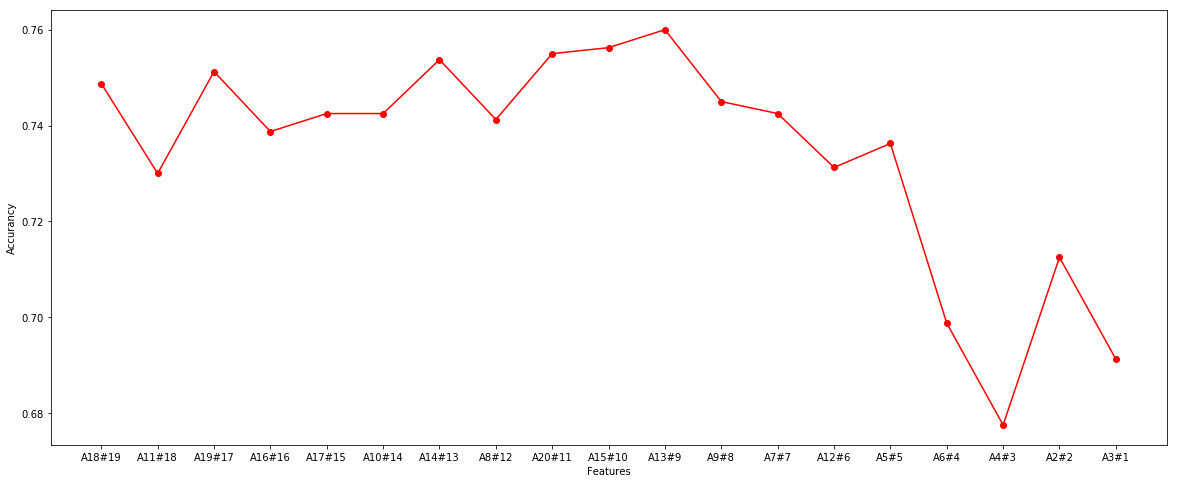

In [87]:
import numpy as np
x_np=np.array(range(len(information_gain_sorted)-1,0,-1))
plt.figure(figsize=(20, 8))
plt.xticks(x_np,x_data)
plt.plot(x_np,values,"ro-")
plt.xlabel("Features")
plt.ylabel("Accurancy")
plt.show()

# Random Forest For The Test Set
We use some of the features

In [88]:
#Keep the best categories from the research we did above
best_cat_not_needed=cat_not_needed.copy()
best_cat_not_needed+=["Attribute18","Attribute11","Attribute19","Attribute16","Attribute17","Attribute10","Attribute14","Attribute8","Attribute20","Attribute15",]
best_cat_needed=df.columns.difference(best_cat_not_needed)

In [89]:
test_df=pd.read_csv("datasets/test.tsv",delimiter="\t")
# print(test_df)
final_test_df=test_df[best_cat_needed].copy()
for a_cat in cat_cat:
    if(a_cat in best_cat_needed):
        the_cat_new=pd.Categorical(test_df[a_cat],categories=cat_trans[a_cat])
        final_test_df[a_cat]=the_cat_new.codes

In [90]:
best_clf_ever=RandomForestClassifier()
best_clf_ever.fit(new_df[best_cat_needed],new_df["Label"])
my_predictons=best_clf_ever.predict(final_test_df)


# Write The Prediction At The File 

In [91]:
my_file=open("testSet_Predictions.csv","w")
for a_clasifier in ["Client_ID","Predicted_Label"]:
    my_file.write(a_clasifier+"\t")
my_file.write("\n")
for i in range(len(my_predictons)):
    my_file.write(str(test_df["Id"][i])+"\t")
    if(my_predictons[i]==1):
        my_file.write("Good\n")
    else:
        my_file.write("Bad\n")

my_file.write("\n")
my_file.close()
print("Done writting testSet_Predictions.csv")

Done writting testSet_Predictions.csv
